#### Classificador de gravidade de vítimas em uma situação de resgate
##### Equipe: Juliana Viscenheski, Maria Fernanda Azolin, Mariana Bittencourt Junghans

#### Classificador 1: Decision Tree

In [2]:
#libraries for data manipulation
import pandas as pd   
import numpy as np

#libraries for prediction and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

#library for the decision tree
from sklearn import tree

#library for oversampling
from imblearn.over_sampling import RandomOverSampler, SMOTE

#libraries for visualization
import graphviz

In [3]:
# library to save the models
import joblib

In [4]:
#set maximum columns for visualization
pd.options.display.max_columns = 50

In [5]:
# read the data
df_victims = pd.read_csv('env_vital_signals.txt', delimiter=',',header=None)

In [6]:
# visualize the dataframe
df_victims.head()

,0,1,2,3,4,5,6,7
0,0,14.968414,14.869604,8.652291,122.324349,5.623564,25.868691,2
1,1,16.397160,12.220855,8.733333,135.824333,12.787053,35.650207,2
2,2,21.624540,13.586879,8.733333,97.100546,1.553286,37.109058,2
3,3,16.458690,1.904802,-4.333333,6.943670,8.233419,27.122605,2
4,4,18.521669,13.700638,8.733333,22.887924,0.738972,13.222719,1


In [7]:
#Set the column names
df_victims.columns = ['Id','pSist','pDiast','qPA','pulso','resp','grav','label']

In [8]:
# visualize the dataframe
df_victims.head()

,Id,pSist,pDiast,qPA,pulso,resp,grav,label
0,0,14.968414,14.869604,8.652291,122.324349,5.623564,25.868691,2
1,1,16.397160,12.220855,8.733333,135.824333,12.787053,35.650207,2
2,2,21.624540,13.586879,8.733333,97.100546,1.553286,37.109058,2
3,3,16.458690,1.904802,-4.333333,6.943670,8.233419,27.122605,2
4,4,18.521669,13.700638,8.733333,22.887924,0.738972,13.222719,1


In [9]:
df_victims['label'].value_counts()

label
2    2332
3     989
1     620
4      59
Name: count, dtype: int64

In [10]:
#Check the dataframe info
df_victims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      4000 non-null   int64  
 1   pSist   4000 non-null   float64
 2   pDiast  4000 non-null   float64
 3   qPA     4000 non-null   float64
 4   pulso   4000 non-null   float64
 5   resp    4000 non-null   float64
 6   grav    4000 non-null   float64
 7   label   4000 non-null   int64  
dtypes: float64(6), int64(2)
memory usage: 250.1 KB


In [11]:
#Discard the columns that are not going to be used for prediction
df_victims.drop(['pSist','pDiast','grav'], axis=1, inplace=True)

In [12]:
# visualize the dataframe
df_victims.head()

,Id,qPA,pulso,resp,label
0,0,8.652291,122.324349,5.623564,2
1,1,8.733333,135.824333,12.787053,2
2,2,8.733333,97.100546,1.553286,2
3,3,-4.333333,6.943670,8.233419,2
4,4,8.733333,22.887924,0.738972,1


In [13]:
#Check the dataframe metrics
df_victims.describe()

,Id,qPA,pulso,resp,label
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,1999.500000,2.035925,99.396236,10.971920,2.121750
std,1154.844867,5.609896,57.836513,6.380008,0.668235
min,0.000000,-8.733333,0.014052,0.002916,1.000000
25%,999.750000,-4.333333,49.321590,5.408188,2.000000
50%,1999.500000,3.966917,99.424857,11.126667,2.000000
75%,2999.250000,8.348437,149.140467,16.538838,3.000000
max,3999.000000,8.733333,199.889794,21.996464,4.000000


In [14]:
# visualize the dataframe
df_victims.head()

,Id,qPA,pulso,resp,label
0,0,8.652291,122.324349,5.623564,2
1,1,8.733333,135.824333,12.787053,2
2,2,8.733333,97.100546,1.553286,2
3,3,-4.333333,6.943670,8.233419,2
4,4,8.733333,22.887924,0.738972,1


In [15]:
# Select data for modeling
X=df_victims.drop(['label'], axis=1)
y=df_victims['label']

In [16]:
# Instantiate the random oversampler
oversampler = SMOTE(random_state=42)

# Fit and apply the random oversampler
X, y = oversampler.fit_resample(X, y)

In [17]:
# Create a decision tree classifier
clf = tree.DecisionTreeClassifier(max_depth=10)

In [18]:
# Perform cross-validation with 5 folds
scores = cross_val_score(clf, X, y, cv=5)  # 5-fold cross-validation

In [19]:
print("Cross-validation scores:", scores)

Cross-validation scores: [0.73954984 0.90300107 0.8772776  0.88364611 0.76300268]


In [20]:
# Split the data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [21]:
# Fit the model with train data
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10)

In [22]:
y_pred = clf.predict(X_test)

In [23]:
print(classification_report(y_test, y_pred, target_names=['Crítico','Instável','Potencialmente estável','Estável']))

                        precision    recall  f1-score   support

               Crítico       0.87      0.85      0.86       455
              Instável       0.83      0.86      0.84       471
Potencialmente estável       0.93      0.90      0.91       458
               Estável       0.97      1.00      0.98       482

              accuracy                           0.90      1866
             macro avg       0.90      0.90      0.90      1866
          weighted avg       0.90      0.90      0.90      1866



In [24]:
# Use graphviz to plot the tree
# dot_data = tree.export_graphviz(clf, out_file=None,
# feature_names=X.columns,
# class_names=['Crítico','Instável','Potencialmente estável','Estável'],
# filled=True,
# rounded=True)
# graph = graphviz.Source(dot_data)

# graph

#### Pré-teste cego com 800 vítimas

In [25]:
df_test = pd.read_csv('env_vital_signals_test.txt',sep=',',header=None)

In [26]:
df_test.head()

,0,1,2,3,4,5,6,7
0,0,15.701721,14.145122,8.721732,160.904175,20.926336,13.404672,1
1,1,18.907009,12.220855,8.733333,134.454047,17.972046,34.192304,2
2,2,14.698109,13.586879,8.614814,86.302237,4.168373,40.000000,2
3,3,16.428095,1.904802,-4.333333,138.880782,2.721256,27.122605,2
4,4,14.616501,13.700638,8.602531,51.356913,18.061923,47.188993,2


In [27]:
#Set the column names
df_test.columns = ['Id','pSist','pDiast','qPA','pulso','resp','grav','label']

In [28]:
#Discard the columns that are not going to be used for prediction
df_test.drop(['pSist','pDiast','grav'], axis=1, inplace=True)

In [29]:
# Select data for modeling
X=df_test.drop(['label'], axis=1)
y=df_test['label']

In [30]:
# Predict for the 800 victim dataset
y_pred2 = clf.predict(X)

In [31]:
print(classification_report(y, y_pred2, target_names=['Crítico','Instável','Potencialmente estável','Estável']))

                        precision    recall  f1-score   support

               Crítico       0.72      0.99      0.83       119
              Instável       0.95      0.86      0.90       455
Potencialmente estável       0.89      0.88      0.89       211
               Estável       0.69      0.73      0.71        15

              accuracy                           0.88       800
             macro avg       0.81      0.87      0.83       800
          weighted avg       0.90      0.88      0.89       800



In [32]:
df_test.head()

,Id,qPA,pulso,resp,label
0,0,8.721732,160.904175,20.926336,1
1,1,8.733333,134.454047,17.972046,2
2,2,8.614814,86.302237,4.168373,2
3,3,-4.333333,138.880782,2.721256,2
4,4,8.602531,51.356913,18.061923,2


In [33]:
# Create the dataframe to generate the output file
df_predicted = pd.DataFrame(columns=['Id','x','y','grav','classe'])

In [34]:
df_predicted

,Id,x,y,grav,classe


In [35]:
# Set the Id column
df_predicted['Id'] = df_test['Id']

In [36]:
# Set x, y, grav columns as zero
df_predicted['x'] = 0
df_predicted['y'] = 0
df_predicted['grav'] = 0

In [37]:
df_predicted

,Id,x,y,grav,classe
0,0,0,0,0,NaN
1,1,0,0,0,NaN
2,2,0,0,0,NaN
3,3,0,0,0,NaN
4,4,0,0,0,NaN
...,...,...,...,...,...
795,795,0,0,0,NaN
796,796,0,0,0,NaN
797,797,0,0,0,NaN
798,798,0,0,0,NaN


In [38]:
# Set the 'classe' column as the predicted labels
df_predicted['classe'] = pd.Series(y_pred2)

In [39]:
df_predicted

,Id,x,y,grav,classe
0,0,0,0,0,1
1,1,0,0,0,2
2,2,0,0,0,2
3,3,0,0,0,2
4,4,0,0,0,2
...,...,...,...,...,...
795,795,0,0,0,1
796,796,0,0,0,2
797,797,0,0,0,2
798,798,0,0,0,2


In [40]:
df_predicted['classe'].value_counts()

classe
2    412
3    208
1    164
4     16
Name: count, dtype: int64

In [41]:
df_predicted.to_csv('pred.txt',sep=',',header=None,index=False)

In [42]:
# Save the trained model to a file
joblib.dump(clf, 'decision_tree_model.joblib')

['decision_tree_model.joblib']

In [43]:
import pickle

pickle.dump(clf, open("decision_tree_model.pkl", "wb"))

#### Classificador 2: Fuzzy

In [44]:
#fuzzy library
import skfuzzy as fuzz
from skfuzzy import control as ctrl

In [45]:
#libraries for data manipulation
import numpy as np
import pandas as pd

In [46]:
#libraries for prediction and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

In [47]:
# library to save the models
import joblib

In [48]:
# Create the input variable arrays (universes)
x_qpa = np.arange(-10,11,0.1)
x_pulsacao = np.arange(0,201,1)
x_respiracao = np.arange(0,23,1)
x_gravidade = np.arange(0,101,1)

In [49]:
# Create the input variables for the fuzzy system
qpa = ctrl.Antecedent(x_qpa,'qPA')
pulsacao = ctrl.Antecedent(x_pulsacao,'Pulsacao')
respiracao = ctrl.Antecedent(x_respiracao,'Respiracao')
gravidade = ctrl.Consequent(x_gravidade,'Gravidade')

In [50]:
# Create the membership function for blood pressure
# Partitions:
# -10 <= qPA < -3 igual a Baixa
# -3 <= qPA < 3 igual a Normal
# 3 <= qPA <= 10 igual a Alta
qpa['Baixa'] = fuzz.trimf(x_qpa,[-10,-6.5,-3])
qpa['Normal'] = fuzz.trimf(x_qpa,[-6.5,-3,3])
qpa['Alta'] = fuzz.trimf(x_qpa,[-3,3,10])

In [51]:
# Create the membership function for pulsation
# Partitions:
# pulsacao < 55bpm igual a Baixa
# 55 bpm <= pulsacao <= 120bpm igual a Normal
# pulsacao > 120bpm igual a Alta
pulsacao['Baixa'] = fuzz.trimf(x_pulsacao,[0,27.5,55])
pulsacao['Normal'] = fuzz.trimf(x_pulsacao,[27.5,55,120])
pulsacao['Alta'] = fuzz.trimf(x_pulsacao,[55,120,200])

In [52]:
# Create the membership function for breathing
# Partitions:
# respiracao < 11fr igual a Baixa
# 11 fr <= respiracao <= 21fr igual a Normal
# respiracao > 21fr igual a Alta
respiracao['Baixa'] = fuzz.trimf(x_respiracao,[0,5.5,11])
respiracao['Normal'] = fuzz.trimf(x_respiracao,[5.5,11,21])
respiracao['Alta'] = fuzz.trimf(x_respiracao,[11,21,22])

In [53]:
# Create the membership function for gravity
# Partitions:
# 0 <= gravidade <= 25 igual a Crítico
# 25 < gravidade <= 50 igual a Instável
# 50 < gravidade <= 75 igual a Potencialmente Estável
# 75 < gravidade <= 100 igual a Estável
gravidade['Crítico'] = fuzz.trimf(x_gravidade,[0,12.5,25])
gravidade['Instável'] = fuzz.trimf(x_gravidade,[12.5,25,50])
gravidade['Potencialmente Estável'] = fuzz.trimf(x_gravidade,[25,50,75])
gravidade['Estável'] = fuzz.trimf(x_gravidade,[50,75,100])

c:\Users\julia\AppData\Local\Programs\Python\Python39\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


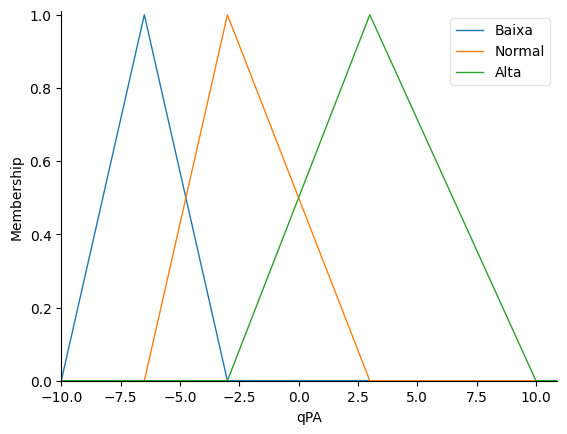

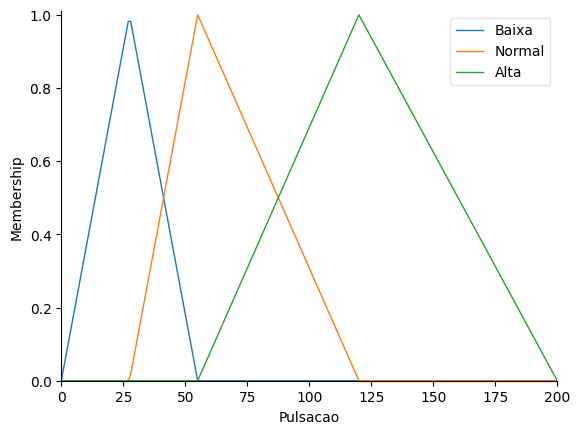

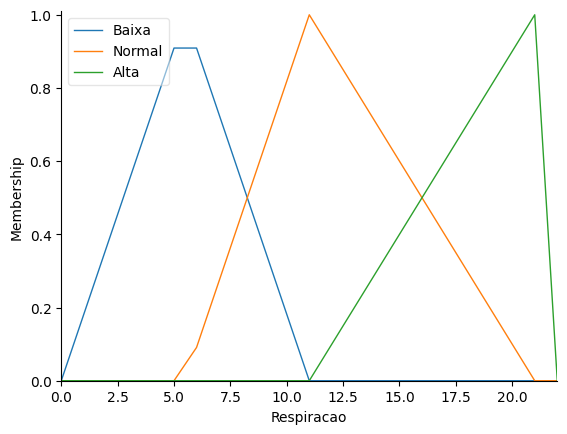

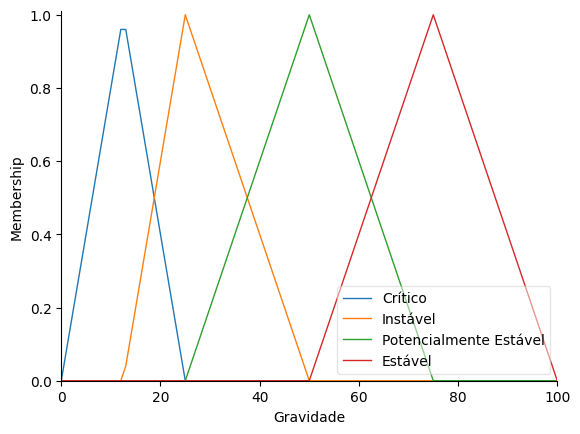

In [54]:
qpa.view()
pulsacao.view()
respiracao.view()
gravidade.view()

In [55]:
#Creation of the fuzzy rules
# Possible values:
# qPA: Baixa, Normal, Alta
# Pulsação: Baixa, Normal, Alta
# Respiração: Baixa, Normal, Alta
rule1 = ctrl.Rule(qpa['Baixa'] & pulsacao['Baixa'] & respiracao['Baixa'], gravidade['Crítico'])
rule2 = ctrl.Rule(qpa['Baixa'] & pulsacao['Baixa'] & respiracao['Normal'], gravidade['Instável'])
rule3 = ctrl.Rule(qpa['Baixa'] & pulsacao['Baixa'] & respiracao['Alta'], gravidade['Crítico'])
rule4 = ctrl.Rule(qpa['Baixa'] & pulsacao['Normal'] & respiracao['Baixa'], gravidade['Instável'])
rule5 = ctrl.Rule(qpa['Baixa'] & pulsacao['Normal'] & respiracao['Normal'], gravidade['Instável'])
rule6 = ctrl.Rule(qpa['Baixa'] & pulsacao['Normal'] & respiracao['Alta'], gravidade['Instável'])
rule7 = ctrl.Rule(qpa['Baixa'] & pulsacao['Alta'] & respiracao['Baixa'], gravidade['Crítico'])
rule8 = ctrl.Rule(qpa['Baixa'] & pulsacao['Alta'] & respiracao['Normal'], gravidade['Instável'])
rule9 = ctrl.Rule(qpa['Baixa'] & pulsacao['Alta'] & respiracao['Alta'], gravidade['Crítico'])
rule10 = ctrl.Rule(qpa['Normal'] & pulsacao['Baixa'] & respiracao['Baixa'], gravidade['Instável'])
rule11 = ctrl.Rule(qpa['Normal'] & pulsacao['Baixa'] & respiracao['Normal'], gravidade['Instável'])
rule12 = ctrl.Rule(qpa['Normal'] & pulsacao['Baixa'] & respiracao['Alta'], gravidade['Instável'])
rule13 = ctrl.Rule(qpa['Normal'] & pulsacao['Normal'] & respiracao['Baixa'], gravidade['Potencialmente Estável'])
rule14 = ctrl.Rule(qpa['Normal'] & pulsacao['Normal'] & respiracao['Normal'], gravidade['Estável'])
rule15 = ctrl.Rule(qpa['Normal'] & pulsacao['Normal'] & respiracao['Alta'], gravidade['Potencialmente Estável'])
rule16 = ctrl.Rule(qpa['Normal'] & pulsacao['Alta'] & respiracao['Baixa'], gravidade['Instável'])
rule17 = ctrl.Rule(qpa['Normal'] & pulsacao['Alta'] & respiracao['Normal'], gravidade['Potencialmente Estável'])
rule18 = ctrl.Rule(qpa['Normal'] & pulsacao['Alta'] & respiracao['Alta'], gravidade['Instável'])
rule19 = ctrl.Rule(qpa['Alta'] & pulsacao['Baixa'] & respiracao['Baixa'], gravidade['Crítico'])
rule20 = ctrl.Rule(qpa['Alta'] & pulsacao['Baixa'] & respiracao['Normal'], gravidade['Instável'])
rule21 = ctrl.Rule(qpa['Alta'] & pulsacao['Baixa'] & respiracao['Alta'], gravidade['Crítico'])
rule22 = ctrl.Rule(qpa['Alta'] & pulsacao['Normal'] & respiracao['Baixa'], gravidade['Instável'])
rule23 = ctrl.Rule(qpa['Alta'] & pulsacao['Normal'] & respiracao['Normal'], gravidade['Instável'])
rule24 = ctrl.Rule(qpa['Alta'] & pulsacao['Normal'] & respiracao['Alta'], gravidade['Instável'])
rule25 = ctrl.Rule(qpa['Alta'] & pulsacao['Alta'] & respiracao['Baixa'], gravidade['Instável'])
rule26 = ctrl.Rule(qpa['Alta'] & pulsacao['Alta'] & respiracao['Normal'], gravidade['Instável'])
rule27 = ctrl.Rule(qpa['Alta'] & pulsacao['Alta'] & respiracao['Alta'], gravidade['Crítico'])

In [56]:
# Build fuzzy system
fuzzy_ctrl = ctrl.ControlSystem([rule1,rule2,rule3,rule4,rule5,rule6,rule7,rule8,rule9,rule10,rule11,rule12,
                                  rule13,rule14,rule15,rule16,rule17,rule18,rule19,rule20,rule21,rule22,rule23,
                                  rule24,rule25,rule26,rule27])
fuzzy = ctrl.ControlSystemSimulation(fuzzy_ctrl)

In [57]:
fuzzy.input['qPA'] = 0
fuzzy.input['Pulsacao'] = 80
fuzzy.input['Respiracao'] = 19

43.70139400029639


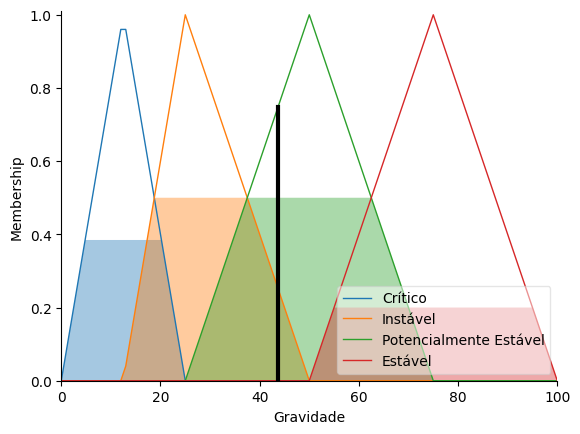

In [58]:
fuzzy.compute()
print(fuzzy.output['Gravidade'])
gravidade.view(sim=fuzzy)

In [59]:
#Load the dataset
df_victims = pd.read_csv('env_vital_signals.txt',header=None)

In [60]:
#Set the column names
df_victims.columns = ['Id','pSist','pDiast','qPA','pulso','resp','grav','label']

In [61]:
df_victims.head()

,Id,pSist,pDiast,qPA,pulso,resp,grav,label
0,0,14.968414,14.869604,8.652291,122.324349,5.623564,25.868691,2
1,1,16.397160,12.220855,8.733333,135.824333,12.787053,35.650207,2
2,2,21.624540,13.586879,8.733333,97.100546,1.553286,37.109058,2
3,3,16.458690,1.904802,-4.333333,6.943670,8.233419,27.122605,2
4,4,18.521669,13.700638,8.733333,22.887924,0.738972,13.222719,1


In [62]:
df_victims.describe()

,Id,pSist,pDiast,qPA,pulso,resp,grav,label
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,1999.500000,14.805740,7.586298,2.035925,99.396236,10.971920,40.584062,2.121750
std,1154.844867,4.658186,4.293059,5.609896,57.836513,6.380008,16.019954,0.668235
min,0.000000,5.000000,0.005122,-8.733333,0.014052,0.002916,13.222719,1.000000
25%,999.750000,11.588170,3.841093,-4.333333,49.321590,5.408188,28.683128,2.000000
50%,1999.500000,15.440755,7.651051,3.966917,99.424857,11.126667,40.000000,2.000000
75%,2999.250000,18.579543,11.263132,8.348437,149.140467,16.538838,50.503774,3.000000
max,3999.000000,21.993204,14.996888,8.733333,199.889794,21.996464,87.000000,4.000000


In [63]:
# Select the stable victims
df_stable = df_victims[df_victims['label'] == 4]

In [64]:
df_stable.head(10)

,Id,pSist,pDiast,qPA,pulso,resp,grav,label
145,145,8.407991,6.027121,0.000000,74.725916,19.157960,84.898654,4
209,209,11.902434,9.337126,-0.000000,57.527259,14.500449,80.734360,4
239,239,11.848169,6.362501,-0.000000,55.236820,15.601078,79.617296,4
278,278,11.906483,5.012446,-0.000000,86.795956,12.351801,79.211758,4
312,312,9.239718,7.778924,-0.000000,67.975351,19.897297,80.337479,4
346,346,13.118509,6.342534,2.497584,89.515946,14.830677,79.578398,4
374,374,8.139177,6.423795,-0.000000,108.934128,14.587328,79.123605,4
403,403,12.395282,8.977855,1.075199,76.855352,17.169973,77.161250,4
410,410,7.913017,4.793996,-3.056093,78.746423,20.513523,77.638333,4
426,426,11.870640,4.215080,-2.660137,69.543817,16.908133,77.639812,4


In [65]:
df_stable.describe()

,Id,pSist,pDiast,qPA,pulso,resp,grav,label
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.0
mean,2084.474576,10.953870,6.663438,-0.057245,83.826494,16.313187,81.841469,4.0
std,1174.247791,2.846909,1.722246,1.096292,13.386304,2.406806,3.515607,0.0
min,145.000000,6.454695,4.122171,-3.116504,55.236820,11.856112,75.633180,4.0
25%,1159.500000,9.067846,4.913280,-0.000000,74.425004,14.667222,79.597847,4.0
50%,2198.000000,10.505463,6.644020,0.000000,85.243085,15.792718,80.734360,4.0
75%,3069.500000,11.904459,8.024048,-0.000000,90.879532,17.715914,85.159539,4.0
max,3945.000000,19.916174,9.770525,2.497584,116.642719,21.876676,87.000000,4.0


In [66]:
#Discard the columns that are not going to be used for prediction
df_victims.drop(['pSist','pDiast','grav'], axis=1, inplace=True)

In [67]:
# Select data for modeling
X=df_victims.drop(['label'], axis=1)
y=df_victims['label']

In [68]:
# Function to predict the label based on the fuzzy logic
def predict_fuzzy_gravity_label(X):
    predicted = []
    for i in X.index:
        fuzzy.input['qPA'] = X.loc[i,'qPA']
        fuzzy.input['Pulsacao'] = X.loc[i,'pulso']
        fuzzy.input['Respiracao'] = X.loc[i,'resp']
        fuzzy.compute()
        defuzz_value = fuzzy.output['Gravidade']
        if (defuzz_value >= 0 and defuzz_value <= 25):
            predicted.append(1) #Crítico
        elif (defuzz_value > 25 and defuzz_value <= 50):
            predicted.append(2) #Instável
        elif (defuzz_value > 50 and defuzz_value <= 75):
            predicted.append(3) #Potencialmente estável
        else:
            predicted.append(4) #Estável
    return predicted

In [69]:
# Function to perform k-fold cross-validation using the fuzzy model
def k_fold_cross_validation(X, y, k=5, random_state=None):
    np.random.seed(random_state)
    n = len(X)
    fold_size = n // k
    indices = np.random.permutation(n)
    scores = []
    for i in range(k):
        # Split data into training and testing sets
        test_indices = indices[i * fold_size: (i + 1) * fold_size]
        X_test, y_test = X.loc[test_indices,:], y[test_indices]

        # Evaluate the model on the testing data
        y_pred = predict_fuzzy_gravity_label(X_test)
        correct_predictions = np.sum(y_test == y_pred)
        total_predictions = len(y_test)
        accuracy = correct_predictions / total_predictions
        scores.append(accuracy)
    return scores

In [70]:
scores = k_fold_cross_validation(X,y, random_state=42)

In [71]:
print(scores)

[0.44625, 0.4325, 0.49125, 0.48, 0.435]


In [72]:
# Split the data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [73]:
# Predict using fuzzy
y_pred = predict_fuzzy_gravity_label(X_test)

In [74]:
len(y_pred)

800

In [75]:
print(classification_report(y_test, y_pred, target_names=['Crítico','Instável','Potencialmente estável','Estável']))

                        precision    recall  f1-score   support

               Crítico       0.24      0.52      0.33       139
              Instável       0.57      0.60      0.59       454
Potencialmente estável       0.64      0.08      0.14       202
               Estável       0.00      0.00      0.00         5

              accuracy                           0.45       800
             macro avg       0.36      0.30      0.26       800
          weighted avg       0.53      0.45      0.43       800



c:\Users\julia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\julia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\julia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [76]:
df_test = pd.read_csv('env_vital_signals_test.txt',sep=',',header=None)

In [77]:
#Set the column names
df_test.columns = ['Id','pSist','pDiast','qPA','pulso','resp','grav','label']

In [78]:
#Discard the columns that are not going to be used for prediction
df_test.drop(['pSist','pDiast','grav'], axis=1, inplace=True)

In [79]:
# Select data for modeling
X=df_test.drop(['label'], axis=1)
y=df_test['label']

In [80]:
# Predict for the 800 victim dataset
y_pred2 = predict_fuzzy_gravity_label(X)

In [81]:
print(classification_report(y, y_pred2, target_names=['Crítico','Instável','Potencialmente estável','Estável']))

                        precision    recall  f1-score   support

               Crítico       0.21      0.48      0.30       119
              Instável       0.57      0.62      0.59       455
Potencialmente estável       0.59      0.09      0.16       211
               Estável       0.00      0.00      0.00        15

              accuracy                           0.45       800
             macro avg       0.34      0.30      0.26       800
          weighted avg       0.51      0.45      0.42       800



c:\Users\julia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\julia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\julia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif